In [9]:
import sed_vis
import dcase_util
import sys
sys.path.append('../')
from trainer import SED

import torch
import yaml
from encoder import ManyHotEncoder
from utils import classes_labels
from model import CRNN
import pandas as pd
from desed_task.dataio.datasets import StronglyAnnotatedSet

In [10]:
with open("../params.yaml", "r") as f:
    config = yaml.safe_load(f)

encoder = ManyHotEncoder(
    list(classes_labels.keys()),
    audio_len=config["data"]["audio_max_len"],
    frame_len=config["feats"]["n_filters"],
    frame_hop=config["feats"]["hop_length"],
    net_pooling=config["data"]["net_subsample"],
    fs=config["data"]["fs"],
)

sed = SED(config, encoder=encoder, sed=CRNN(**config["net"]))
print(sed.state_dict().keys())

path = '../DvcLiveLogger/dvclive_run/checkpoints/epoch=27-step=23352.ckpt'
state_dict = torch.load(path)["state_dict"]
sed.load_state_dict(state_dict)

tsv_entries_strong = pd.read_csv(config["data"]["test_tsv"], sep = '\t')
dataset_strong = StronglyAnnotatedSet(audio_folder = config["data"]["test_folder"], 
                                  tsv_entries = tsv_entries_strong, 
                                  encoder=encoder,
                                  return_filename=True,
                                  pad_to=config["data"]["audio_max_len"],)

odict_keys(['sed.cnn.cnn.conv0.weight', 'sed.cnn.cnn.conv0.bias', 'sed.cnn.cnn.batchnorm0.weight', 'sed.cnn.cnn.batchnorm0.bias', 'sed.cnn.cnn.batchnorm0.running_mean', 'sed.cnn.cnn.batchnorm0.running_var', 'sed.cnn.cnn.batchnorm0.num_batches_tracked', 'sed.cnn.cnn.conv1.weight', 'sed.cnn.cnn.conv1.bias', 'sed.cnn.cnn.batchnorm1.weight', 'sed.cnn.cnn.batchnorm1.bias', 'sed.cnn.cnn.batchnorm1.running_mean', 'sed.cnn.cnn.batchnorm1.running_var', 'sed.cnn.cnn.batchnorm1.num_batches_tracked', 'sed.cnn.cnn.conv2.weight', 'sed.cnn.cnn.conv2.bias', 'sed.cnn.cnn.batchnorm2.weight', 'sed.cnn.cnn.batchnorm2.bias', 'sed.cnn.cnn.batchnorm2.running_mean', 'sed.cnn.cnn.batchnorm2.running_var', 'sed.cnn.cnn.batchnorm2.num_batches_tracked', 'sed.cnn.cnn.conv3.weight', 'sed.cnn.cnn.conv3.bias', 'sed.cnn.cnn.batchnorm3.weight', 'sed.cnn.cnn.batchnorm3.bias', 'sed.cnn.cnn.batchnorm3.running_mean', 'sed.cnn.cnn.batchnorm3.running_var', 'sed.cnn.cnn.batchnorm3.num_batches_tracked', 'sed.cnn.cnn.conv4.weigh

In [11]:
sed(dataset_strong[0][0])

tensor([[[0.0103, 0.0145, 0.0043,  ..., 0.0234, 0.0193, 0.0112],
         [0.0299, 0.0224, 0.0289,  ..., 0.0092, 0.0463, 0.0437],
         [0.0161, 0.0187, 0.0045,  ..., 0.0042, 0.0087, 0.0066],
         ...,
         [0.1914, 0.1382, 0.0578,  ..., 0.0442, 0.0320, 0.0356],
         [0.0594, 0.0597, 0.0111,  ..., 0.0655, 0.1119, 0.1059],
         [0.6489, 0.3695, 0.8068,  ..., 0.4126, 0.5513, 0.5040]]],
       grad_fn=<TransposeBackward0>)

In [47]:
from utils import batched_decode_preds
i = 39
# i = 253
preds = batched_decode_preds(sed(dataset_strong[i][0]), dataset_strong[i][3], encoder)
print(dataset_strong[i][3])
preds[2][0.5][['onset', 'offset', 'event_label']].to_csv('preds.tsv', index=False, sep='\t')
preds[2][0.5][['onset', 'offset', 'event_label']]

/mnt/d/DESED_dataset/audio/validation/validation_16k/Y1NYJAJXYyNY_350.000_360.000.wav


,onset,offset,event_label
0,1.920,9.808,Electric_shaver_toothbrush
1,1.456,2.192,Speech
2,4.064,5.104,Speech


In [48]:
ref_df = pd.read_csv(config["data"]["test_tsv"], sep = '\t')
ref_df = ref_df[ref_df['filename'] == dataset_strong[i][3].split('/')[-1]].reset_index().drop(columns = ['index'])
ref_df.drop('filename', axis = 1).to_csv('ref.tsv', index = False, sep='\t')
ref_df

,filename,onset,offset,event_label
0,Y1NYJAJXYyNY_350.000_360.000.wav,0.483,10.000,Frying
1,Y1NYJAJXYyNY_350.000_360.000.wav,1.354,2.233,Speech
2,Y1NYJAJXYyNY_350.000_360.000.wav,4.041,5.037,Speech
3,Y1NYJAJXYyNY_350.000_360.000.wav,7.513,7.764,Dishes
4,Y1NYJAJXYyNY_350.000_360.000.wav,9.047,9.676,Dishes


In [49]:
import numpy as np
# Load audio signal first
audio_container = dcase_util.containers.AudioContainer().load(
    f"/mnt/d/DESED_dataset/audio/validation/validation_16k/{dataset_strong[i][3].split('/')[-1]}"
)
audio_container.data = np.mean(audio_container.data, axis=0)

In [50]:
audio_container.data.shape

(160000,)

TypeError: __init__() got an unexpected keyword argument 'span_stays'

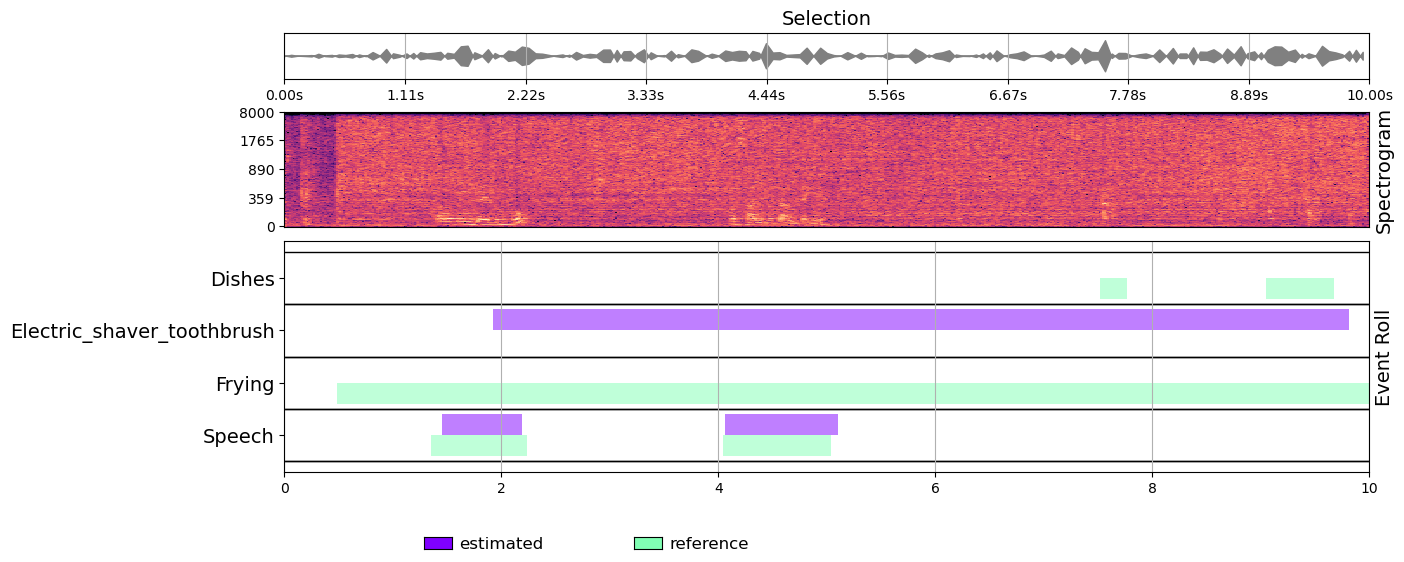

In [51]:

# Load event lists
reference_event_list = dcase_util.containers.MetaDataContainer().load(
    'ref.tsv'
)
estimated_event_list = dcase_util.containers.MetaDataContainer().load(
    'preds.tsv'
)

event_lists = {
    'reference': reference_event_list, 
    'estimated': estimated_event_list
}

# Visualize the data
vis = sed_vis.visualization.EventListVisualizer(event_lists=event_lists,
                                                audio_signal=audio_container.data,
                                                sampling_rate=audio_container.fs)
vis.show()

In [52]:
import IPython.display as ipd

ipd.Audio(audio_container.data, rate=audio_container.fs)